In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 

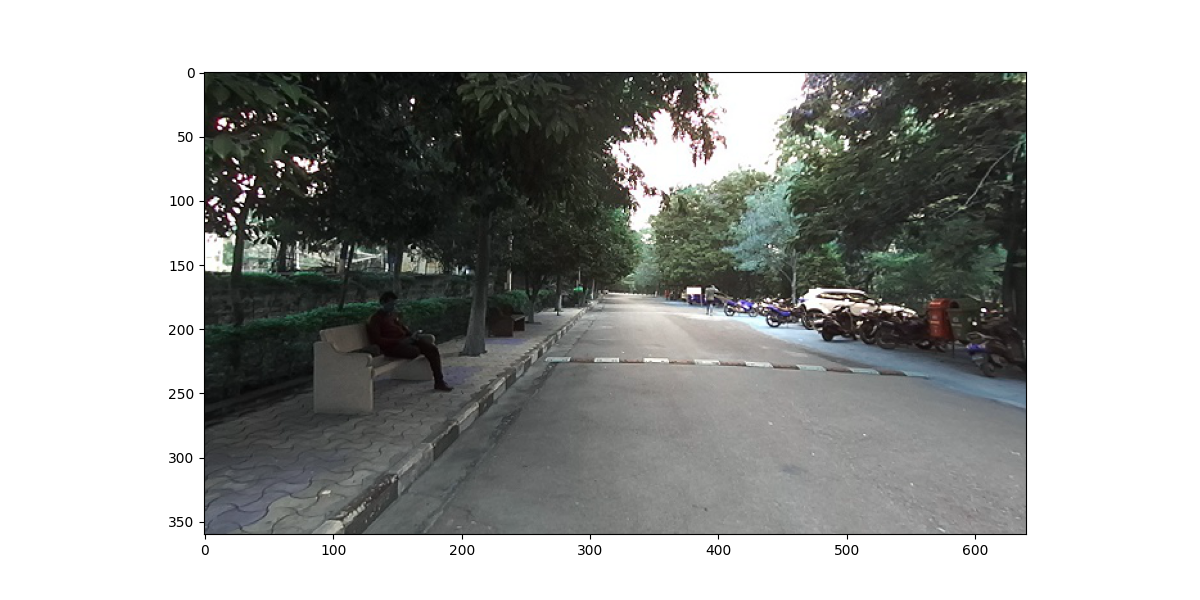

In [2]:
test_img = cv2.imread('../KITTI_visual_odometry/campus_data/stereo/left/frame79_54599827.jpg')
plt.figure(figsize=(12,6))
plt.imshow(test_img)

In [3]:
class Dataset_Handler():
    def __init__(self):
        
       
       
        self.seq_dir = '../KITTI_visual_odometry/campus_data/stereo/'
        
        # Get names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'left')
        self.left_image_files= sorted(self.left_image_files)
        self.right_image_files = os.listdir(self.seq_dir + 'right')
        self.right_image_files= sorted(self.right_image_files) #####to rectify random sequences###
        self.num_frames = len(self.left_image_files)
        
        
       
        self.reset_frames()
        # Store original frame to memory for testing functions
        self.first_image_left = cv2.imread(self.seq_dir + 'left/' 
                                            + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'right/' 
                                            + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'left/' 
                                            + self.left_image_files[1], 0)
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
        
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'left/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'right/' + name_right, 0)
                            for name_right in self.right_image_files)
        pass


In [4]:
handler = Dataset_Handler()

In [5]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    
  
    sad_window = 6  #tuning.
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

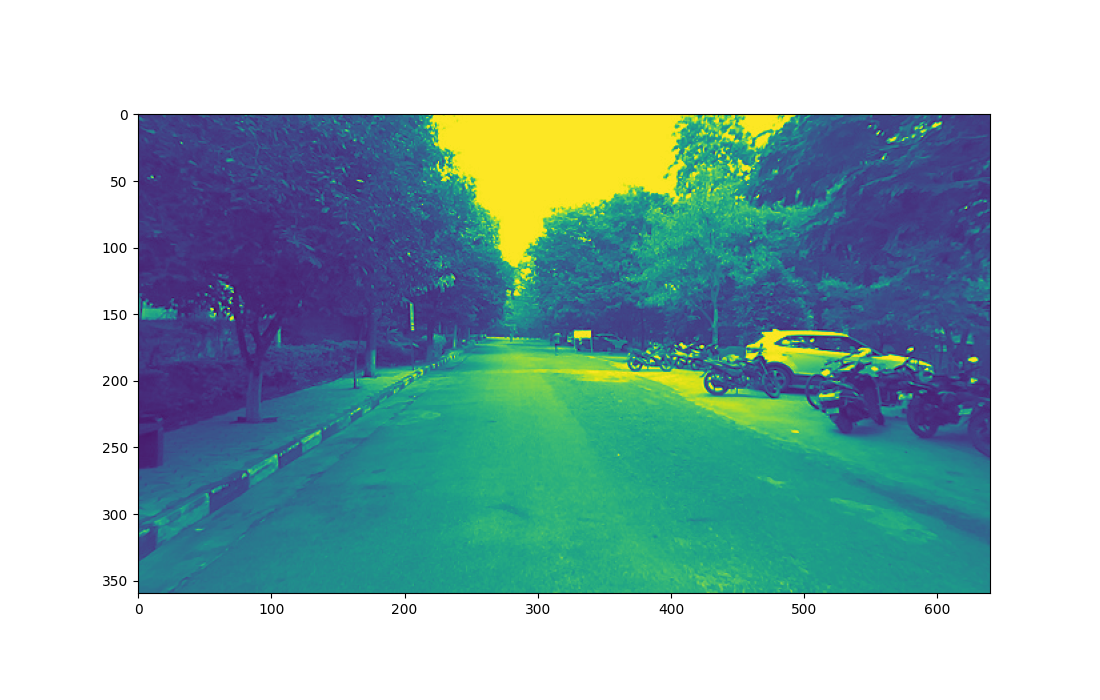

In [6]:
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_left);

Time to compute disparity map using StereoBM: 0:00:00.019597


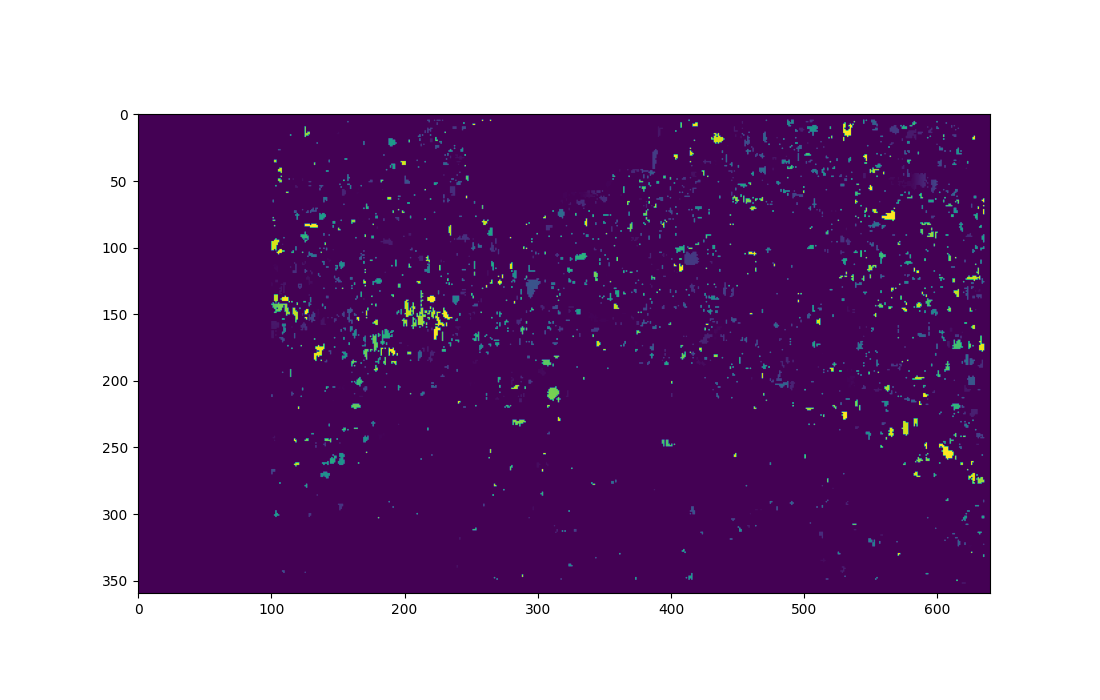

In [7]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM: 0:00:00.015881


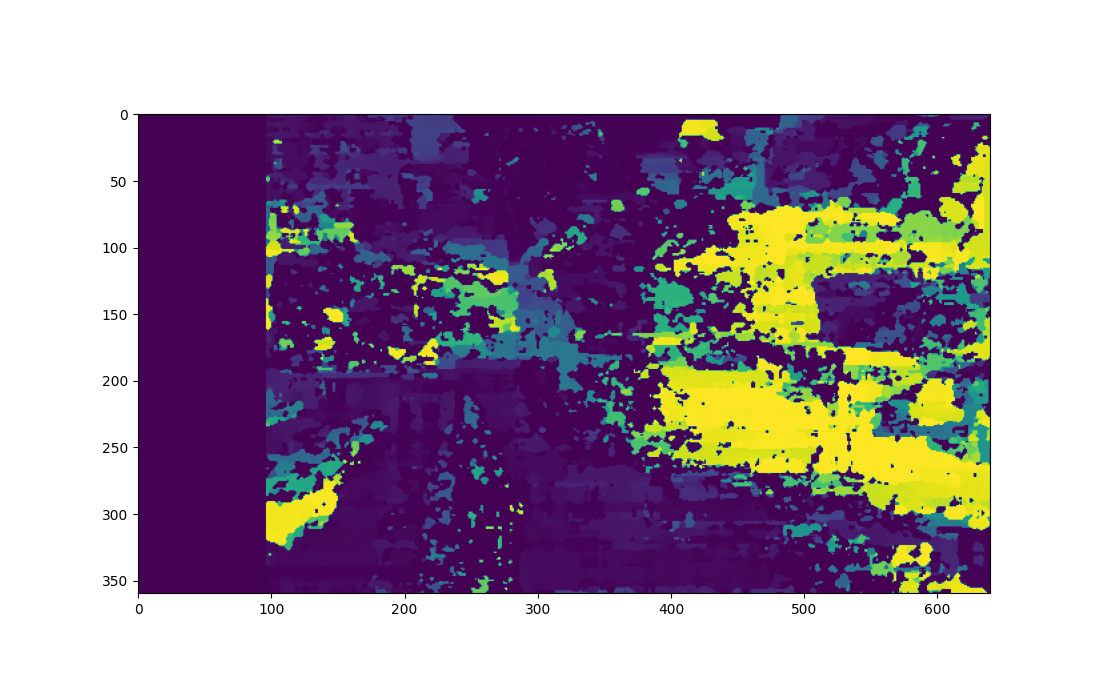

In [8]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [9]:
def calc_depth_map(disp_left, k_left):
    
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    

    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * 12/ disp_left
    
    return depth_map

In [68]:
def stereo_2_depth(img_left, img_right, k_left, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):

    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left)
    
    return depth

In [69]:
def extract_features(image, detector='sift', mask=None):
  
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
   
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [70]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
   
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
   
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [71]:
def filter_matches_distance(matches, dist_threshold):


    filtered_match = []
    
    for m, n in matches:
        
        if m.distance <= dist_threshold*n.distance: 
            filtered_match.append(m)

    return filtered_match

In [72]:
def visualize_matches(image1, kp1, image2, kp2, match):
    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [73]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
   
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])
   
    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

       
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
       
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
        print(object_points)   
        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        if len(image1_points)>4:

            _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
            
            rmat = cv2.Rodrigues(rvec)[0]
    

    
    return rmat, tvec, image1_points, image2_points

In [74]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    
   
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))

    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
   
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left=  np.array([[336.3924560546875, 0.0, 307.7497863769531], 
              [0.0, 336.3924560546875, 165.84719848632812], 
              [0.0, 0.0, 1.0]])
    
    
    handler.reset_frames()
    image_plus1 = next(handler.images_left)
    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        
        start = datetime.datetime.now()
       
    
        image_left = image_plus1
        image_right = next(handler.images_right)
        # Get next frame in the left camera for visual odometry
        image_plus1 = next(handler.images_left)
        
       
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   k_left,
                                   matcher=stereo_matcher)
     
        else:
            depth = None
  
            
       
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
       
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter 
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
     
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
      
        Tmat = np.eye(4)
      
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

In [75]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [76]:

start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        filter_match_distance=0.8, 
                                        detector='sift',
                                        stereo_matcher='sgbm',
                                        mask=mask,     
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)




Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.8*distance
[[ 1.10197587e+01  1.65770224e+00  4.63989601e+01]
 [-1.11681084e+01 -3.86804999e+00  6.03620110e+01]
 [-5.23789805e+00 -5.84223590e+00  4.35224724e+01]
 [ 8.48352796e+00 -2.73738190e+01  1.07287956e+02]
 [ 4.61891256e+00  2.29047038e+00  1.39799469e+02]
 [ 1.28286983e+01  5.40286619e+00  1.04679665e+02]
 [ 3.51502211e+01 -4.40499539e+01  1.33998657e+02]
 [ 5.21950305e+01 -8.53588340e+01  3.47243835e+02]
 [-5.21778941e+00 -1.14224545e+01  1.78418091e+02]
 [ 5.21950305e+01 -8.53588340e+01  3.47243835e+02]
 [ 1.31088946e+01  3.33334857e+00  4.53562851e+01]
 [-1.05253776e+01 -4.06979130e-01  1.09100258e+02]
 [ 1.63957539e+01  3.81244150e+00  5.45501289e+01]
 [ 8.37919067e+00 -1.55937656e+01  5.40932579e+01]
 [ 1.78207230e+01  5.74345209e+00  4.24916801e+01]
 [-4.19732968e+01  9.29252516e+00  1.95719254e+02]
 [ 4.23436700e+01 -9.83342728e+01  5.208

In [77]:
#np.savetxt('trajectory.csv', trajectory_nolidar_bm.reshape(-1, trajectory_nolidar_bm.shape[-1]), delimiter=',')
np.savetxt('trajectory_campus_stereo.csv', trajectory_nolidar_bm.reshape(-1, trajectory_nolidar_bm.shape[-1]), delimiter=',')

In [78]:
# Load the trajectory back from the CSV file
# loaded_trajectory = np.loadtxt('trajectory.csv', delimiter=',')
loaded_trajectory = np.loadtxt('trajectory_campus_stereo.csv', delimiter=',')
# Reshape the loaded data back to the original shape if needed
loaded_trajectory = loaded_trajectory.reshape(120,3,4)


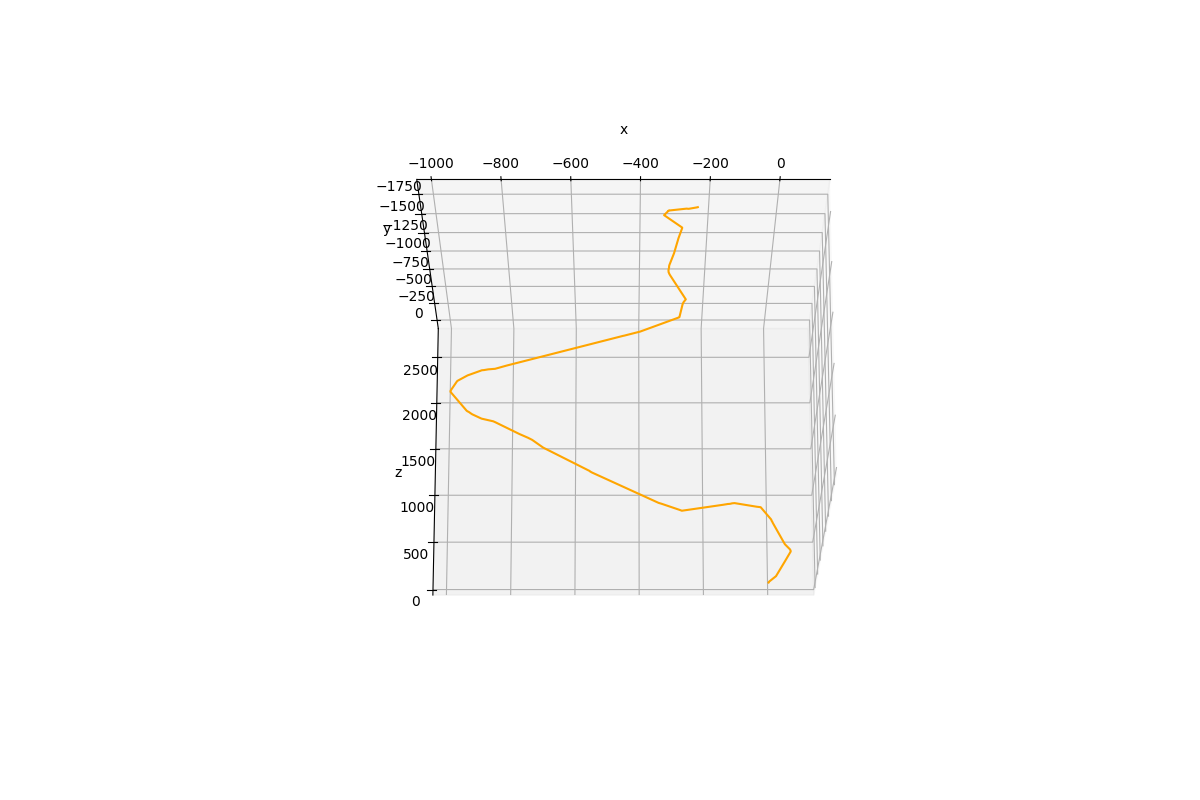

In [79]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(loaded_trajectory[:, :, 3][:, 0], 
        loaded_trajectory[:, :, 3][:, 1], 
        loaded_trajectory[:, :, 3][:, 2], label='estimated', color='orange')



ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [80]:
start = datetime.datetime.now()
trajectory_nolidar_sgbm = visual_odometry(handler,
                                          filter_match_distance=0.5, 
                                          detector='sift',
                                          stereo_matcher='sgbm',
                                          mask=mask,     
                                          subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
[[ 1.10197587e+01  1.65770224e+00  4.63989601e+01]
 [-1.11681084e+01 -3.86804999e+00  6.03620110e+01]
 [-5.23789805e+00 -5.84223590e+00  4.35224724e+01]
 [ 8.48352796e+00 -2.73738190e+01  1.07287956e+02]
 [ 4.61891256e+00  2.29047038e+00  1.39799469e+02]
 [ 1.28286983e+01  5.40286619e+00  1.04679665e+02]
 [ 3.51502211e+01 -4.40499539e+01  1.33998657e+02]
 [ 5.21950305e+01 -8.53588340e+01  3.47243835e+02]
 [-5.21778941e+00 -1.14224545e+01  1.78418091e+02]
 [ 5.21950305e+01 -8.53588340e+01  3.47243835e+02]
 [ 1.31088946e+01  3.33334857e+00  4.53562851e+01]
 [-1.05253776e+01 -4.06979130e-01  1.09100258e+02]
 [ 1.63957539e+01  3.81244150e+00  5.45501289e+01]
 [ 8.37919067e+00 -1.55937656e+01  5.40932579e+01]
 [ 1.78207230e+01  5.74345209e+00  4.24916801e+01]
 [-4.19732968e+01  9.29252516e+00  1.95719254e+02]
 [ 4.23436700e+01 -9.83342728e+01  5.208

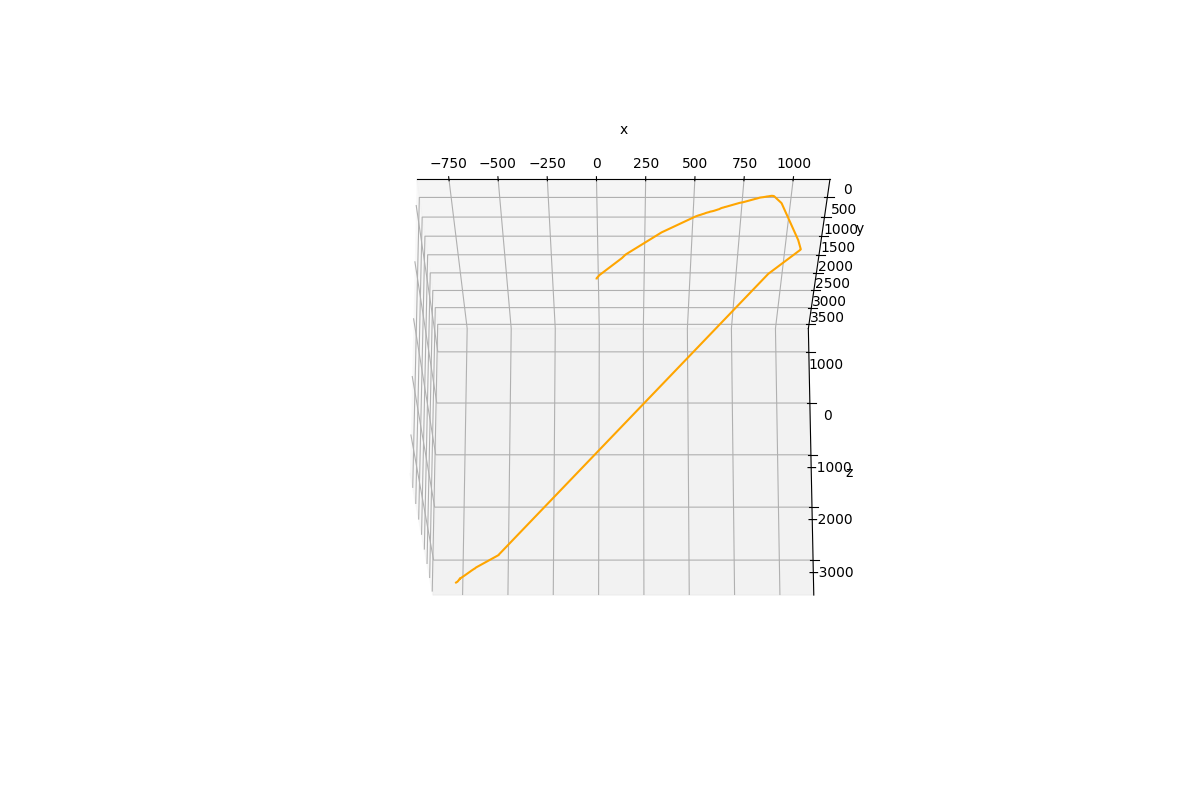

In [81]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_sgbm[:, :, 3][:, 0], 
        trajectory_nolidar_sgbm[:, :, 3][:, 1], 
        trajectory_nolidar_sgbm[:, :, 3][:, 2], label='estimated', color='orange')


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)